# **Neural steering controller for autonomous parking**

This tutorial implements the physics-driven neural steering controller of the paper titled:

*Fast Planning and Tracking of Complex Autonomous Parking Maneuvers With Optimal Control and Pseudo-Neural Networks*

(available at https://ieeexplore.ieee.org/abstract/document/10309845)

## Initialization

### Import packages

In [43]:
import sys
import os
import torch
import pandas as pd
import scipy as sp

print('Current working directory: ',os.getcwd())
sys.path.append(os.path.join(os.getcwd(),'..'))
from neu4mes import *
from neu4mes import relation
from neu4mes import earlystopping
relation.NeuObj_names = []  # reset the list of NeuObj names

# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

# enable zooming on the plots
%matplotlib inline
import mpld3
mpld3.enable_notebook()


Current working directory:  /Users/mattiapiccinini/Documents/Research/Neu4Mes/tutorials


### Configurations, known constant parameters and initial guesses

In [44]:
# Path to the data folder
data_folder = os.path.join(os.getcwd(),'datasets','control_steer_car_parking')

# Import the file with the vehicle data
vehicle_data_csv = os.path.join(data_folder,'other_data','vehicle_data.csv')
# Extract the vehicle data
L = pd.read_csv(vehicle_data_csv)['L'][0]  # [m] wheelbase

# Import the file with the steering maps
steer_maps_file = os.path.join(data_folder,'other_data','steer_map.txt')
steer_map_load  = np.loadtxt(steer_maps_file, delimiter='\t', skiprows=1)
delta_w_avg_map = np.float64(np.deg2rad(steer_map_load[:,0]))  # [rad] average steering angle at the front wheels
delta_sw_map    = np.float64(np.deg2rad(steer_map_load[:,1]))  # [rad] steering wheel angle

# Initial guesses
# Load the initial guesses for the curvature diagram approximation, computed in Matlab with a 2nd order optimizer
initial_guesses_curv_diagr = sp.io.loadmat(os.path.join(data_folder,'other_data','initial_guesses_curv_diagram','fit_curv_diagr_5th_ord_poly.mat'))
curv_diagram_params_guess = initial_guesses_curv_diagr['optim_params_poly'][0].astype('float64')

## NN model

### Custom parametric functions

In [45]:
# Curvature diagram
def curvat_diagram(curv,L,h_1,h_2,h_3):
  return torch.atan(h_1*curv + h_2*torch.pow(curv,3) + h_3*torch.pow(curv,5) + curv*L)

# Steering maps
def steer_map_spline(x):
  # Inputs: 
  # x: average steering angle at the front wheels [rad]
  # x_data: map of average steering angles at the front wheels (delta_w_avg_map) [rad]
  # y_data: map of steering wheel angles (delta_sw_map) [rad]
  # Output:
  # y: steering wheel angle [rad]
  x_data = torch.tensor([-0.6417, -0.6288, -0.6158, -0.6028, -0.5899, -0.5769, -0.5639, -0.5510,
                         -0.5380, -0.5251, -0.5121, -0.4991, -0.4862, -0.4732, -0.4602, -0.4473,
                         -0.4343, -0.4213, -0.4084, -0.3954, -0.3824, -0.3695, -0.3565, -0.3436,
                         -0.3306, -0.3176, -0.3047, -0.2917, -0.2787, -0.2658, -0.2528, -0.2398,
                         -0.2269, -0.2139, -0.2009, -0.1880, -0.1750, -0.1621, -0.1491, -0.1361,
                         -0.1232, -0.1102, -0.0972, -0.0843, -0.0713, -0.0583, -0.0454, -0.0324,
                         -0.0194, -0.0065,  0.0065,  0.0194,  0.0324,  0.0454,  0.0583,  0.0713,
                         0.0843,  0.0972,  0.1102,  0.1232,  0.1361,  0.1491,  0.1621,  0.1750,
                         0.1880,  0.2009,  0.2139,  0.2269,  0.2398,  0.2528,  0.2658,  0.2787,
                         0.2917,  0.3047,  0.3176,  0.3306,  0.3436,  0.3565,  0.3695,  0.3824,
                         0.3954,  0.4084,  0.4213,  0.4343,  0.4473,  0.4602,  0.4732,  0.4862,
                         0.4991,  0.5121,  0.5251,  0.5380,  0.5510,  0.5639,  0.5769,  0.5899,
                         0.6028,  0.6158,  0.6288,  0.6417])
  y_data = torch.tensor([-12.5664, -12.3177, -12.0690, -11.8203, -11.5716, -11.3229, -11.0742,
                         -10.8255, -10.5768, -10.3281, -10.0794,  -9.8307,  -9.5799,  -9.3286,
                          -9.0772,  -8.8258,  -8.5745,  -8.3231,  -8.0718,  -7.8204,  -7.5691,
                          -7.3177,  -7.0663,  -6.8126,  -6.5576,  -6.3026,  -6.0476,  -5.7926,
                          -5.5376,  -5.2826,  -5.0276,  -4.7727,  -4.5177,  -4.2627,  -4.0055,
                          -3.7475,  -3.4895,  -3.2315,  -2.9735,  -2.7155,  -2.4574,  -2.1994,
                          -1.9414,  -1.6834,  -1.4254,  -1.1663,  -0.9071,  -0.6480,  -0.3888,
                          -0.1296,   0.1296,   0.3888,   0.6480,   0.9071,   1.1663,   1.4254,
                           1.6834,   1.9414,   2.1994,   2.4574,   2.7155,   2.9735,   3.2315,
                           3.4895,   3.7475,   4.0055,   4.2627,   4.5177,   4.7727,   5.0276,
                           5.2826,   5.5376,   5.7926,   6.0476,   6.3026,   6.5576,   6.8126,
                           7.0663,   7.3177,   7.5691,   7.8204,   8.0718,   8.3231,   8.5745,
                           8.8258,   9.0772,   9.3286,   9.5799,   9.8307,  10.0794,  10.3281,
                          10.5768,  10.8255,  11.0742,  11.3229,  11.5716,  11.8203,  12.0690,
                          12.3177,  12.5664])

  # Linear interpolation of the steering map:
  # Find the indices of the intervals containing each x
  indices = torch.searchsorted(x_data, x, right=True).clamp(1, len(x_data) - 1)
  
  # Get the values for the intervals
  x1 = x_data[indices - 1]
  x2 = x_data[indices]
  y1 = y_data[indices - 1]
  y2 = y_data[indices]
  
  # Linear interpolation formula
  y = y1 + (y2 - y1) * (x - x1) / (x2 - x1)
  
  # Saturate the output if x is out of bounds
  y = torch.where(x < x_data[0], y_data[0], y)    # Saturate to minimum y_data
  y = torch.where(x > x_data[-1], y_data[-1], y)  # Saturate to maximum y_data
  return y

### Internal architecture

In [46]:
# Neural model inputs and outputs
curv         = Input('curv')          # [1/m] path curvature
steer        = Input('steer')         # [rad] steering wheel angle 
steer_target = Input('steer_target')  # [rad] steering wheel angle --> this is used only as a training target

num_samples_future_curv = 15   # number of samples in the future for the curvature prediction
num_samples_past_steer  = 15   # number of samples in the past for the steering wheel angle prediction

# Trainable parameters:
# Curvature diagram parameters
h_1_guess = Parameter('h_1',values=[[curv_diagram_params_guess[0]]])  # initial guess
h_2_guess = Parameter('h_2',values=[[curv_diagram_params_guess[1]]])  # initial guess
h_3_guess = Parameter('h_3',values=[[curv_diagram_params_guess[2]]])  # initial guess

# Parametric function to learn the curvature diagram 
out_curv_diagr = ParamFun(curvat_diagram,parameters=[h_1_guess,h_2_guess,h_3_guess])(curv.sw([0,num_samples_future_curv]),L.item())

# FIR layer to weigh the future predictions of the curvature diagram
out_fir        = Fir(parameter='fir_future_curv', parameter_init=init_negexp, 
                     parameter_init_params={'size_index':0, 'first_value':0.1, 'lambda':5})(out_curv_diagr)   

# Parametric function to model the steering map (i.e., the relation between the average steering angle at the front wheels and the steering wheel angle)
out_steer_map  = ParamFun(steer_map_spline)(out_fir)   

# FIR layer to weigh the past steering wheel angles computed by the NN (auto-regressive model)
out_arx        = Fir(parameter='fir_auto_regression', parameter_init=init_negexp, 
                     parameter_init_params={'size_index':0, 'first_value':1e-3, 'lambda':5})(steer.sw([-num_samples_past_steer,0]))  

# Output of the neural model
out = Output('steering_angle', out_steer_map + out_arx)

### Neu4Mes framework

In [47]:
# Create a neu4mes model
steer_controller_park = Neu4mes(visualizer='Standard',seed=0,workspace=os.path.join(os.getcwd(),'trained_models'))  #visualizer=MPLVisulizer()

# Add the neural model to the neu4mes structure and neuralization of the model
steer_controller_park.addModel('steer_ctrl',[out])
steer_controller_park.addMinimize('steer_error', 
                                  steer_target.next(),  # next means the first value in the "future"
                                  out, 
                                  loss_function='mse')
steer_controller_park.neuralizeModel()

================================ Neu4mes Model =================================
{'Constants': {'Constant49': {'dim': 1, 'values': 2.6}},
 'Functions': {'FParamFun48': {'code': 'def '
                                       'curvat_diagram(curv,L,h_1,h_2,h_3):\n'
                                       '  return torch.atan(h_1*curv + '
                                       'h_2*torch.pow(curv,3) + '
                                       'h_3*torch.pow(curv,5) + curv*L)\n',
                               'n_input': 2,
                               'name': 'curvat_diagram',
                               'parameters': ['h_1', 'h_2', 'h_3']},
               'FParamFun51': {'code': 'def steer_map_spline(x):\n'
                                       '  # Inputs: \n'
                                       '  # x: average steering angle at the '
                                       'front wheels [rad]\n'
                                       '  # x_data: map of average steering '
        

## Training and validation datasets

In [48]:
# Load the training and the validation dataset
data_struct = ['curv',('steer','steer_target')]  # both steer and steer_target are read from the same column of the csv file
data_folder_train = os.path.join(data_folder,'training')
data_folder_valid = os.path.join(data_folder,'validation')
data_folder_test  = os.path.join(data_folder,'test')
steer_controller_park.loadData(name='training_set', source=data_folder_train, format=data_struct, skiplines=1)
steer_controller_park.loadData(name='validation_set', source=data_folder_valid, format=data_struct, skiplines=1)
steer_controller_park.loadData(name='test_set', source=data_folder_test, format=data_struct, skiplines=1)

# check the definition of the windows in the inputs and outputs
#samples_test_set = steer_controller_park.get_samples('training_set', index=100, window=1) 
#print(samples_test_set)

============================ Neu4mes Model Dataset =============================
Dataset Name:                 training_set
Number of files:              1
Total number of samples:      3092
Shape of steer:               (3092, 15, 1)
Shape of curv:                (3092, 15, 1)
Shape of steer_target:        (3092, 1, 1)
============================ Neu4mes Model Dataset =============================
Dataset Name:                 validation_set
Number of files:              1
Total number of samples:      832
Shape of steer:               (832, 15, 1)
Shape of curv:                (832, 15, 1)
Shape of steer_target:        (832, 1, 1)
============================ Neu4mes Model Dataset =============================
Dataset Name:                 test_set
Number of files:              1
Total number of samples:      691
Shape of steer:               (691, 15, 1)
Shape of curv:                (691, 15, 1)
Shape of steer_target:        (691, 1, 1)


## Training

### Train the NN in open-loop (no auto-regressive term)

In [49]:
num_epochs = 6000
batch_size = 100
learn_rate = 1e-3  # learning rate
early_stop_patience = 100
training_pars_open_loop = {'num_of_epochs':num_epochs, 
                           'val_batch_size':batch_size, 
                           'train_batch_size':batch_size, 
                           'lr':learn_rate}

steer_controller_park.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
                                 training_params=training_pars_open_loop, optimizer='Adam', shuffle_data=True,
                                 early_stopping=earlystopping.early_stop_valid_patience, early_stopping_params={'patience':early_stop_patience})  

======================== Neu4mes Model Train Parameters ========================
models:                       ['steer_ctrl']
train dataset:                training_set
train {batch size, samples}:  {100, 3092}
val dataset:                  validation_set
val {batch size, samples}:    {100, 832}
num of epochs:                6000
shuffle data:                 True
early stopping:               early_stop_valid_patience
early stopping params:        {'patience': 100}
minimize:                     {'steer_error': {'A': 'SamplePart91',
                                               'B': 'steering_angle',
                                               'loss': 'mse'}}
optimizer:                    Adam
optimizer defaults:           {'lr': 0.001}
optimizer params:             [{'params': 'fir_auto_regression'},
                               {'params': 'fir_future_curv'},
                               {'params': 'h_1'},
                               {'params': 'h_2'},
                     

({'steer_error': [7.015847682952881,
   0.5094313621520996,
   0.2673436999320984,
   0.17716509103775024,
   0.11733150482177734,
   0.07959505170583725,
   0.0569063164293766,
   0.04444005712866783,
   0.03848409280180931,
   0.03530024364590645,
   0.034438300877809525,
   0.03366449847817421,
   0.033590931445360184,
   0.033390387892723083,
   0.033948495984077454,
   0.03247792646288872,
   0.03236522525548935,
   0.031583238393068314,
   0.032367270439863205,
   0.032420169562101364,
   0.03210094943642616,
   0.03158062323927879,
   0.03121575526893139,
   0.03145674243569374,
   0.029961803928017616,
   0.030318446457386017,
   0.029994962736964226,
   0.029601873829960823,
   0.028831828385591507,
   0.02918366529047489,
   0.028634659945964813,
   0.028593415394425392,
   0.028639061376452446,
   0.028096001595258713,
   0.027871649712324142,
   0.027255872264504433,
   0.02731505036354065,
   0.026422040536999702,
   0.026191985234618187,
   0.02613476663827896,
   0.02533

In [50]:
# Print the trained NN parameters
steer_controller_park.neuralizeModel()

================================ Neu4mes Model =================================
{'Constants': {'Constant49': {'dim': 1, 'values': 2.6}},
 'Functions': {'FParamFun48': {'code': 'def '
                                       'curvat_diagram(curv,L,h_1,h_2,h_3):\n'
                                       '  return torch.atan(h_1*curv + '
                                       'h_2*torch.pow(curv,3) + '
                                       'h_3*torch.pow(curv,5) + curv*L)\n',
                               'n_input': 2,
                               'name': 'curvat_diagram',
                               'parameters': ['h_1', 'h_2', 'h_3']},
               'FParamFun51': {'code': 'def steer_map_spline(x):\n'
                                       '  # Inputs: \n'
                                       '  # x: average steering angle at the '
                                       'front wheels [rad]\n'
                                       '  # x_data: map of average steering '
        

### Re-train the NN in auto-regressive mode (closed-loop training)

In [51]:
num_epochs = 1000
batch_size = 100
learn_rate = 1e-3  # learning rate
early_stop_patience = 50
training_pars_closed_loop = {'num_of_epochs':num_epochs, 
                             'val_batch_size':batch_size, 
                             'train_batch_size':batch_size, 
                             'lr':learn_rate}

predict_samples = 50  # number of samples after which the internal state is reset
steps_skip = 1  # number of samples to skip when going to a new window. The default is 1, meaning the size of a batch. If steps_skip = predict_samples, then the whole window size is skipped

# NOTE: by default, the next batch skips a full length of a batch
# NOTE: shuffle = True shuffles only the order of the batches, so it's ok with the autoregression

steer_controller_park.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
                                 training_params=training_pars_closed_loop, optimizer='Adam', shuffle_data=True,
                                 early_stopping=earlystopping.early_stop_valid_patience, early_stopping_params={'patience':early_stop_patience},
                                 prediction_samples=predict_samples, step=steps_skip, closed_loop={'steer':'steering_angle'})  

Recurrent train: closing the loop between the the input ports steer and the output ports steering_angle for 50 samples
======================== Neu4mes Model Train Parameters ========================
models:                       ['steer_ctrl']
train dataset:                training_set
train {batch size, samples}:  {100, 3092}
val dataset:                  validation_set
val {batch size, samples}:    {100, 832}
num of epochs:                1000
shuffle data:                 True
early stopping:               early_stop_valid_patience
early stopping params:        {'patience': 50}
minimize:                     {'steer_error': {'A': 'SamplePart91',
                                               'B': 'steering_angle',
                                               'loss': 'mse'}}
prediction samples:           50
step:                         1
closed loop:                  {'steer': 'steering_angle'}
connect:                      {}
optimizer:                    Adam
optimizer defaults:

({'steer_error': [0.03997763618826866,
   0.0030997893773019314,
   0.0003472528769634664,
   8.384540706174448e-05,
   0.00011977069516433403,
   0.0017528722528368235,
   0.03566117212176323,
   0.055818382650613785,
   0.004252634942531586,
   0.0006967606605030596,
   0.00015941444144118577,
   2.9428196285152808e-05,
   4.512393570621498e-05,
   0.00014863561955280602,
   0.0010021948255598545,
   0.010058725252747536,
   0.07895839959383011,
   0.026261240243911743,
   0.000481663882965222,
   4.571360841509886e-05,
   4.1867195250233635e-05,
   4.130122033529915e-05,
   5.637343929265626e-05,
   0.00011162530427100137,
   0.0003567665407899767,
   0.0017545920563861728,
   0.01138375885784626,
   0.06066142022609711,
   0.037393514066934586,
   0.0013649140018969774,
   0.00015939903096295893,
   3.8400074117816985e-05,
   5.101740316604264e-05,
   7.470222772099078e-05,
   0.00014522024139296263,
   0.00041518639773130417,
   0.0016939014894887805,
   0.00885318685323,
   0.043

### Print the parameters of the trained NN

In [52]:
# Print the trained NN parameters
steer_controller_park.neuralizeModel()

================================ Neu4mes Model =================================
{'Constants': {'Constant49': {'dim': 1, 'values': 2.6}},
 'Functions': {'FParamFun48': {'code': 'def '
                                       'curvat_diagram(curv,L,h_1,h_2,h_3):\n'
                                       '  return torch.atan(h_1*curv + '
                                       'h_2*torch.pow(curv,3) + '
                                       'h_3*torch.pow(curv,5) + curv*L)\n',
                               'n_input': 2,
                               'name': 'curvat_diagram',
                               'parameters': ['h_1', 'h_2', 'h_3']},
               'FParamFun51': {'code': 'def steer_map_spline(x):\n'
                                       '  # Inputs: \n'
                                       '  # x: average steering angle at the '
                                       'front wheels [rad]\n'
                                       '  # x_data: map of average steering '
        

## Test on a new dataset

Different number of samples between inputs [MAX steer_target = 800; MIN steer = 786]


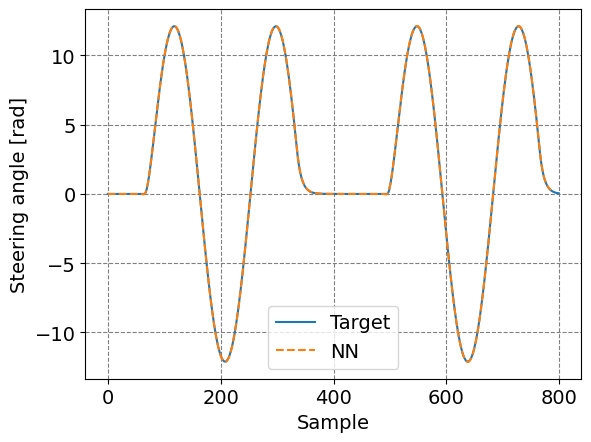

In [95]:
# Test on a new dataset
samples_test_set = steer_controller_park.getSamples('validation_set', index=0, window=800) 
steer_controller_park.resetStates()  # reset the internal state
out_nn_test_set  = steer_controller_park(samples_test_set)

# extract the samples
samples_test_set_extract = np.zeros((len(samples_test_set['steer_target']),1))
for i in range(0,len(samples_test_set_extract)):
  samples_test_set_extract[i] = samples_test_set['steer_target'][i]

out_nn_test_set_extract = np.zeros((len(out_nn_test_set['steering_angle']),1))
for i in range(0,len(out_nn_test_set_extract)):
  out_nn_test_set_extract[i] = out_nn_test_set['steering_angle'][i][0]

# plot the results
plt.figure()
plt.plot(samples_test_set_extract,label='Target')
plt.plot(out_nn_test_set_extract,label='NN',linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Steering angle [rad]')
plt.legend()
plt.grid()
plt.show()

# Test with custom data
#steer_controller_park({'curv':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],'steer':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]})

## Export the trained NN

In [54]:
flag_export_trained_model = False
if flag_export_trained_model:
  # Export the model
  steer_controller_park.neuralizeModel()
  steer_controller_park.exportJSON()

flag_load_trained_model = False
if flag_load_trained_model:
  # Reload the trained model:
  # Load the json file with the model
  json_folder = os.path.join(os.getcwd(),'tutorials','trained_models','neu4mes_2024_10_07_17_50')
  json_file = os.path.join(json_folder,'model.json')
  import json
  # Open and read the JSON file
  with open(json_file, 'r') as file:
      model_trained_json = json.load(file)

  steer_controller_park.model_def = model_trained_json
  # steer_controller_park.trainModel(train_dataset='training_set', validation_dataset='validation_set', 
  #                                  training_params=training_pars_closed_loop, optimizer='Adam', shuffle_data=True,
  #                                  prediction_samples=predict_samples, step=steps_skip,
  #                                  early_stopping=earlystopping.early_stop_valid_patience, early_stopping_params={'exit_tol':1-3})  